In [1]:
import argparse
import sys, os
import time
import json

sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/StyleGAN_DA/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/StyleGAN_DA/gans/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/StyleGAN_DA/src/'))

from itertools import chain

from torch.optim.adam import Adam
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torch import Tensor, nn

from src.examples.autoencoder_penalty import DecoderPenalty, EncoderPenalty
from gan.loss.stylegan import StyleGANLoss
from gan.models.stylegan import StyleGanModel
from src.examples.style_progressive import StyleDisc, StyleTransform
from gan.loss.loss_base import Loss
from gan.loss.perceptual.psp import PSPLoss
from gan.nn.stylegan.generator import Decoder, Generator, FromStyleConditionalGenerator
from gan.nn.stylegan.style_encoder import GradualStyleEncoder
from parameters.run import RuntimeParameters

sys.path.append(os.path.join(sys.path[0], '../'))
sys.path.append(os.path.join(sys.path[0], '../../gans/'))
import torch
from dataset.lazy_loader import LazyLoader
from parameters.path import Paths


This directory already exist
Using existed directory.


In [2]:
import nibabel as nib
import numpy as np
import glob
import os
from tqdm import tqdm
import shutil
import pandas as pd
from torchvision import transforms
from PIL import Image

import torch
from matplotlib import pyplot as plt
from dpipe.im.shape_ops import zoom


In [3]:
def get_dataset_files(path, domain_name, gender='*'):
    if type(domain_name) == 'str':
        return glob.glob(path + f'*{domain_name}*{gender}.nii.gz')
    else:
        result = []
        for domain in domain_name:
            result += glob.glob(path + f'*{domain}*{gender}.nii.gz')
        return result
    
# get_dataset_files('Dataset/Original/', ['philips_15', 'philips_3'])

In [4]:
def scale_mri(image: np.ndarray, q_min: int = 1, q_max: int = 99) -> np.ndarray:
    image = np.clip(np.float32(image), *np.percentile(np.float32(image), [q_min, q_max]))
    image -= np.min(image)
    image /= np.max(image)
    return np.float32(image)

def scale_factor(pict_id, df, new_vowel = (0.95, 0.95, 1)):
    old_voxel_spacing = np.array([df['x'].loc[pict_id], df['y'].loc[pict_id], df['z'].loc[pict_id]])
    scale_factor = old_voxel_spacing / new_vowel
    return np.nan_to_num(scale_factor, nan=1)

def change_2d(x, pict_id, df, spacing_order = 3, with_perc = False):
    pict =  zoom(x, scale_factor(pict_id, df)[1:], order=spacing_order)  
    return scale_mri(pict) if with_perc else pict

def small_preprocessing(img_3d, inter = 10):
    st, en = -1, -1
    for idx, img in enumerate(img_3d):
        if st == -1 and img.mean() > inter:
            st = idx
        elif img.mean() > inter:
            en = idx
    return st, en


In [5]:
def data_preparing(img, file_id, df):
    img_list = []
    st, en = small_preprocessing(img)

    img = img[st:en, ...]
    dim_size, _, _ = img.shape

    for pos in range(dim_size):
        res_img = img[pos, ...]
        im = (change_2d(res_img, file_id, df, with_perc = True) * 255).astype(np.uint8)
        img_list.append(im)
    
    return img_list

In [6]:
def create_dataframe(old_csv_name):
    old_df = pd.read_csv(old_csv_name)
    old_df.set_index('id', inplace=True)
    return old_df[['x', 'y', 'z']]

In [7]:
def get_dataset_files(path, domain_name, gender='*'):
    if type(domain_name) == 'str':
        return glob.glob(path + f'*{domain_name}*{gender}.nii.gz')
    else:
        result = []
        for domain in domain_name:
            result += glob.glob(path + f'*{domain}*{gender}.nii.gz')
        return result
    
def finite_save(save_path):
    path_list = save_path.split(os.sep)
    current = '.'
    
    if os.path.exists(save_path) and len(os.listdir(save_path)):
        shutil.rmtree(save_path)
    
    
    for elem in path_list:
        current += os.sep + elem
        if not os.path.exists(current):
            os.mkdir(current)

    
def save_to_nii(net, path_to_weight_dict, save_path, dataset_files, path_to_csv = 'meta.csv', device='cpu', 
                force_save = False, itt = 'z', sigm_value = 0.5, size = (256, 256)):
    
    roll_dict = {'z':0, 'y':1, 'x':2}
    if itt not in roll_dict:
        print('Wrong itteration value')
        return
    
    df = create_dataframe(path_to_csv)
    transf = transforms.Compose([transforms.Resize([size[0], size[1]]), transforms.PILToTensor()])
    
    net.load_state_dict(torch.load(path_to_weight_dict, map_location=device))
    net.eval()

    if force_save:
        finite_save(save_path)
    
    with torch.no_grad():        
        for brain in dataset_files:
            #Get image name for saving
            filename = os.path.basename(brain)
            
            #We have troubles because of two dots in filename
            filename = filename[:filename.find('.')]
            file_id = filename[:filename.find('_')]
            
            brain_3d_img = nib.load(brain)
            brain_affine = brain_3d_img.affine
            
            brain_3d_img = np.array(brain_3d_img.dataobj)
            brain_3d_img = np.rollaxis(brain_3d_img, roll_dict[itt])

            img_list = data_preparing(brain_3d_img, file_id, df)
            mask_3d_save = np.zeros(shape=(len(img_list), size[0], size[1]))
            for level, img in enumerate(tqdm(img_list)):
                img = transf(Image.fromarray(img))
#                 img = torch.from_numpy(img)
                img = img.to(device).float()

                # Maybe pass function is better?
                mask = net(img[None, ...].float()).sigmoid() > sigm_value
                mask_3d_save[level, ...] = mask
                        
            img = nib.Nifti1Image(mask_3d_save, brain_affine)
            nib.save(img, save_path + filename + '_predicted' + '.nii.gz')  

            
# net = UNet(n_channels=1, n_classes=1,
#            init_features=32, depth=3,
#            image_size=(256, 256), fourier_params = None).to('cpu')
# test_file = ['Dataset/Original/CC0001_philips_15_55_M.nii.gz']
# save_to_nii(net, 'UNet_fourier_None.best.pth', 'test/', test_file, itt= 'y')

In [65]:
weights = torch.load(
    '/raid/data/saved_models/StyleGAN_DA_sm15->ge3_200000.pt',
    map_location="cpu"
)


In [66]:
image_generator = Generator(FromStyleConditionalGenerator(256, 512, style_multiplayer=1)).cuda()

decoder = Decoder(image_generator).cuda()
decoder.load_state_dict(weights['dec'])

style_enc = GradualStyleEncoder(50, 3, mode="ir", style_count=14, style_multiplayer=1).cuda()
style_enc.load_state_dict(weights['enc'])


style_transform = StyleTransform().cuda()
style_transform.load_state_dict(weights['st_trfm'])

style_disc = StyleDisc().cuda()
style_disc.load_state_dict(weights['st_disc'])

<All keys matched successfully>

In [67]:
decoder.eval()
style_enc.eval()
style_transform.eval()
style_disc.eval()

StyleDisc(
  (progressija): ProgressiveWithoutState(
    (0): EqualLinear(512, 512)
    (1): EqualLinear(1024, 512)
    (2): EqualLinear(1024, 512)
    (3): EqualLinear(1024, 512)
    (4): EqualLinear(1024, 512)
    (5): EqualLinear(1024, 512)
    (6): EqualLinear(1024, 512)
    (7): EqualLinear(1024, 512)
    (8): EqualLinear(1024, 512)
    (9): EqualLinear(1024, 512)
    (10): EqualLinear(1024, 512)
    (11): EqualLinear(1024, 512)
    (12): EqualLinear(1024, 512)
    (13): EqualLinear(1024, 512)
  )
  (head): Sequential(
    (0): EqualLinear(512, 512)
    (1): EqualLinear(512, 1)
  )
)

In [18]:
# with torch.no_grad():
    latent_x = style_enc(image_x).detach()
    fake_style = style_transform(latent_x)
    fake_image = decoder.forward([fake_style[:, k] for k in range(fake_style.shape[1])])

NameError: name 'image_x' is not defined

In [ ]:
def get_dataset_files(path, domain_name, gender='*'):
    if type(domain_name) == 'str':
        return glob.glob(path + f'*{domain_name}*{gender}.nii.gz')
    else:
        result = []
        for domain in domain_name:
            result += glob.glob(path + f'*{domain}*{gender}.nii.gz')
        return result

In [57]:
data_list = get_dataset_files('/raid/data/DA_BrainDataset/Dataset/Original/', 'siemens_3')

In [68]:
data_list = (glob.glob('/raid/data/DA_BrainDataset/Dataset/Original/*siemens_15*.nii.gz'))

In [69]:
len(data_list)

60

In [70]:
def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

In [71]:
path_to_csv = '/raid/data/DA_BrainDataset/meta.csv'
device='cuda'
force_save = False
itt = 'z'
sigm_value = 0.5
size = (256, 256)
save_path = '/raid/data/DA_BrainDataset/predictions/sm15_to_ge3/'

roll_dict = {'z':0, 'y':1, 'x':2}
if itt not in roll_dict:
    print('Wrong itteration value')
#     return
    
df = create_dataframe(path_to_csv)
transf = transforms.Compose([transforms.Resize([size[0], size[1]]), transforms.PILToTensor()])
    

if force_save:
    finite_save(save_path)

dataset_files = glob.glob('/raid/data/DA_BrainDataset/Dataset/Original/*siemens_15*.nii.gz')
    
with torch.no_grad():        
    for number, brain in enumerate(dataset_files):
        print(f'{number}/{len(dataset_files)}')
        #Get image name for saving
#         brain = dataset_files[74]
        filename = os.path.basename(brain)

        #We have troubles because of two dots in filename
        filename = filename[:filename.find('.')]
        file_id = filename[:filename.find('_')]

        brain_3d_img = nib.load(brain)
        brain_affine = brain_3d_img.affine

        brain_3d_img = np.array(brain_3d_img.dataobj)
        brain_3d_img = np.rollaxis(brain_3d_img, roll_dict[itt])

        img_list = data_preparing(brain_3d_img, file_id, df)
        mask_3d_save = np.zeros(shape=(len(img_list), size[0], size[1]))
        for level, img in enumerate(tqdm(img_list)):
#             print(len(img_list))
            img = transf(Image.fromarray(img))
            img = img.to(device).float()[None, ...].repeat(1, 3, 1, 1)
            img = (img - img.min())/img.max()
#             print(f'RES shape:{img[0,0].shape}, max:{img[0,0].max()}, min:{img[0,0].min()} ')
#             print(type(img))
            latent_x = style_enc(img).detach()
            fake_style = style_transform(latent_x)
            fake_image = decoder.forward([fake_style[:, k] for k in range(fake_style.shape[1])])
#             print(fake_image[0, 0].shape)
#             print(fake_image[0, 0].max())
#             print(fake_image[0, 0].min())
            res = fake_image[0,0].detach().clamp(min=0)
            res = (res - res.min())/res.max()
            res = res.to('cpu').numpy()
#             break
#             res = img[0,0]
#             print(f'RES shape:{res.shape}, max:{res.max()}, min:{res.min()} ')
###             norm_range(res, value_range=(-1, 1))
#             print(f'RES shape:{img[0,0].shape}, max:{img[0,0].max()}, min:{img[0,0].min()} ')
#             print(f'RES shape:{res.shape}, max:{res.max()}, min:{res.min()} ')
#             f, axarr = plt.subplots(1,2)
#             axarr[0].imshow(img[0,0].to('cpu').numpy())
#             axarr[1].imshow(res.to('cpu').numpy())
#             break

#             # Maybe pass function is better?
#             mask = net(img[None, ...].float()).sigmoid() > sigm_value
            mask_3d_save[level, ...] = res[None,None, ...]
#         print(mask_3d_save.shape)
        img = nib.Nifti1Image(mask_3d_save, brain_affine)
        nib.save(img, save_path + filename + '_predicted' + '.nii.gz')  

#         img = nib.Nifti1Image(mask_3d_save, brain_affine)
#         nib.save(img, save_path + filename + '_predicted' + '.nii.gz')  

0/60


100%|██████████| 175/175 [00:08<00:00, 21.31it/s]


1/60


100%|██████████| 174/174 [00:08<00:00, 21.31it/s]


2/60


100%|██████████| 161/161 [00:07<00:00, 21.34it/s]


3/60


100%|██████████| 180/180 [00:08<00:00, 21.35it/s]


4/60


100%|██████████| 160/160 [00:07<00:00, 21.34it/s]


5/60


100%|██████████| 156/156 [00:07<00:00, 21.30it/s]


6/60


100%|██████████| 169/169 [00:07<00:00, 21.34it/s]


7/60


100%|██████████| 161/161 [00:07<00:00, 21.34it/s]


8/60


100%|██████████| 164/164 [00:07<00:00, 21.32it/s]


9/60


100%|██████████| 177/177 [00:08<00:00, 21.48it/s]


10/60


100%|██████████| 191/191 [00:08<00:00, 21.60it/s]


11/60


100%|██████████| 169/169 [00:07<00:00, 21.61it/s]


12/60


100%|██████████| 161/161 [00:07<00:00, 21.60it/s]


13/60


100%|██████████| 162/162 [00:07<00:00, 21.56it/s]


14/60


100%|██████████| 160/160 [00:07<00:00, 21.60it/s]


15/60


100%|██████████| 165/165 [00:07<00:00, 21.61it/s]


16/60


100%|██████████| 186/186 [00:08<00:00, 21.60it/s]


17/60


100%|██████████| 169/169 [00:07<00:00, 21.57it/s]


18/60


100%|██████████| 176/176 [00:08<00:00, 21.60it/s]


19/60


100%|██████████| 166/166 [00:07<00:00, 21.60it/s]


20/60


100%|██████████| 181/181 [00:08<00:00, 21.59it/s]


21/60


100%|██████████| 172/172 [00:07<00:00, 21.56it/s]


22/60


100%|██████████| 173/173 [00:08<00:00, 21.59it/s]


23/60


100%|██████████| 148/148 [00:06<00:00, 21.60it/s]


24/60


100%|██████████| 170/170 [00:07<00:00, 21.60it/s]


25/60


100%|██████████| 159/159 [00:07<00:00, 21.57it/s]


26/60


100%|██████████| 165/165 [00:07<00:00, 21.60it/s]


27/60


100%|██████████| 168/168 [00:07<00:00, 21.51it/s]


28/60


100%|██████████| 162/162 [00:07<00:00, 21.35it/s]


29/60


100%|██████████| 158/158 [00:07<00:00, 21.30it/s]


30/60


100%|██████████| 170/170 [00:07<00:00, 21.35it/s]


31/60


100%|██████████| 181/181 [00:08<00:00, 21.36it/s]


32/60


100%|██████████| 161/161 [00:07<00:00, 21.35it/s]


33/60


100%|██████████| 164/164 [00:07<00:00, 21.32it/s]


34/60


100%|██████████| 191/191 [00:08<00:00, 21.35it/s]


35/60


100%|██████████| 156/156 [00:07<00:00, 21.35it/s]


36/60


100%|██████████| 175/175 [00:08<00:00, 21.35it/s]


37/60


100%|██████████| 190/190 [00:08<00:00, 21.31it/s]


38/60


100%|██████████| 149/149 [00:06<00:00, 21.35it/s]


39/60


100%|██████████| 173/173 [00:08<00:00, 21.37it/s]


40/60


100%|██████████| 171/171 [00:08<00:00, 21.36it/s]


41/60


100%|██████████| 174/174 [00:08<00:00, 21.33it/s]


42/60


100%|██████████| 179/179 [00:08<00:00, 21.36it/s]


43/60


100%|██████████| 180/180 [00:08<00:00, 21.36it/s]


44/60


100%|██████████| 190/190 [00:08<00:00, 21.35it/s]


45/60


100%|██████████| 180/180 [00:08<00:00, 21.33it/s]


46/60


100%|██████████| 157/157 [00:07<00:00, 21.35it/s]


47/60


100%|██████████| 173/173 [00:08<00:00, 21.36it/s]


48/60


100%|██████████| 145/145 [00:06<00:00, 21.35it/s]


49/60


100%|██████████| 178/178 [00:08<00:00, 21.33it/s]


50/60


100%|██████████| 191/191 [00:08<00:00, 21.36it/s]


51/60


100%|██████████| 160/160 [00:07<00:00, 21.37it/s]


52/60


100%|██████████| 177/177 [00:08<00:00, 21.35it/s]


53/60


100%|██████████| 178/178 [00:08<00:00, 21.33it/s]


54/60


100%|██████████| 160/160 [00:07<00:00, 21.35it/s]


55/60


100%|██████████| 173/173 [00:08<00:00, 21.36it/s]


56/60


100%|██████████| 163/163 [00:07<00:00, 21.36it/s]


57/60


100%|██████████| 166/166 [00:07<00:00, 21.32it/s]


58/60


100%|██████████| 160/160 [00:07<00:00, 21.36it/s]


59/60


100%|██████████| 157/157 [00:07<00:00, 21.36it/s]


In [34]:
for brain in data_list:
            
        filename = os.path.basename(brain)
        filename = filename[:filename.find('.')] #We have troubles because of two dots in filename
        brain_3d_img = nib.load(brain)
        brain_affine = brain_3d_img.affine
        print(brain_affine)
        brain_3d_img = np.array(brain_3d_img.dataobj)

        z, y, x = brain_3d_img.shape
        print(brain_3d_img.shape)
        mask_3d_save = np.zeros_like(brain_3d_img)


        for level in tqdm(range(z)):
            img = brain_3d_img[level, :, :]

            img = torch.from_numpy(img)
            img = img.float().cuda() #to(device).float()
            
            print("QQ", img.shape)
            
            latent_x = style_enc(img[None, None,...]).detach()
            print("qq", latent_x.shape)
            fake_style = style_transform(latent_x)
            print("q", fake_style.shape)
            fake_image = decoder.forward([fake_style[:, k] for k in range(fake_style.shape[1])])
            
            print("QWA", fake_image.shape)
            break
        break
            # Maybe pass function is better?
#             mask = net(img[None,None, ...].float()).sigmoid() > 0.8

# #                 mask = net(img[None, None,...]).to(int).squeeze(0).squeeze(0)
#             mask_3d_save[level,:,:] = mask

# #             plt.imshow(mask_3d_save[120,:,:], cmap = 'gray')
#         img = nib.Nifti1Image(mask_3d_save, brain_affine)
#         break

[[   1.            0.            0.          -94.24698639]
 [   0.            1.            0.         -109.45782471]
 [   0.            0.            1.         -127.        ]
 [   0.            0.            0.            1.        ]]
(192, 256, 256)


  0%|          | 0/192 [00:00<?, ?it/s]

QQ torch.Size([256, 256])
qq torch.Size([1, 14, 512])
q torch.Size([1, 14, 512])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 256, 256])
torch.Size([1, 32, 512, 512])
torch.Size([1, 32, 512, 512])
QWA torch.Size([1, 3, 256, 256])


In [29]:
fake_image[0].detach().to('cpu').numpy().shape

(3, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


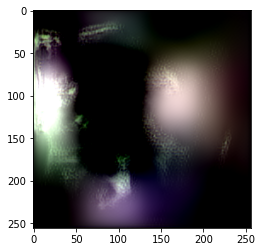

In [30]:
plt.imshow(fake_image[0].detach().to('cpu').permute(1,2,0).numpy())